Learn the inter-grid operator ratio for interface problems using multigrid framework,
* Dataset is constructed by changing RHS 
* Restriction and Prolongation operations are followed by a split operation
* Kernels for some part of fields are learned 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from FEANet.multigrid import MultiGrid

from Utils import plot
from Data.dataset import RHSDataSet

In [2]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [3]:
linear_tensor_R = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 16.0
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_ratio = torch.asarray([4.,1.], dtype=torch.float32)

In [4]:
n = 2**4
model = MultiGrid(n, linear_tensor_R, linear_tensor_P, linear_ratio)
rhs = next(iter(train_dataloader))

0 0.24513234198093414
1 0.05501650646328926
2 0.01746571995317936
3 0.006426169537007809
4 0.0025092570576816797
5 0.0010073049925267696
6 0.00041171981138177216
7 0.0001683122682152316
8 6.939296872587875e-05
9 2.881713953684084e-05
Solution converges after 10 multi-grid iterations 


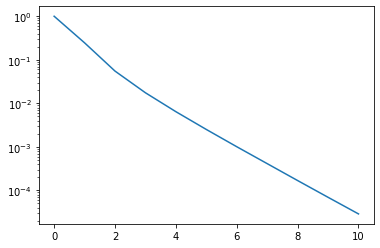

In [5]:
EPS = 5e-5
n_multigrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[1].unsqueeze(0))
err_occured = False
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [6]:
model_dir = 'Model/multigrid_rhs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][0])
print('Restriction kernel shape:', mlist[1].shape)
print('Interpolation kernel:', mlist[2][0][0])
print('Interpolation kernel shape:', mlist[2].shape)

Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 16, 3, 3])
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Interpolation kernel shape: torch.Size([16, 1, 3, 3])


In [7]:
def freeze_kernels(para_list, list):
    '''Freeze the kernels in list, second and third term are R and P'''
    for i in list:
        para_list[1].grad[:,i] = torch.zeros_like(para_list[1].grad[:,i])
        para_list[2].grad[i,:] = torch.zeros_like(para_list[2].grad[i,:])
        

def rewrite_kernels(para_list, list, kernels):
    '''Overwrite the kernels in list to be 'kernels', second and third term are R and P '''
    for i in list:
        para_list[1].grad[:,i] = kernels[0]
        para_list[2].grad[i,:] = kernels[1]

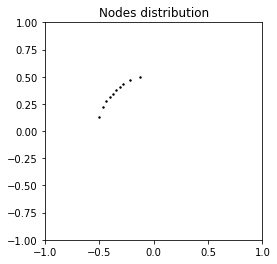

In [8]:
mesh = MeshHandler(outfile="Results/plate_mesh.vtk")
plot.plot_pattern(mesh, key=5)

In [9]:
freeze_list = [0,1,2,3,4,6,7,8,9,10,11,12,13,14,15] # freeze 5-th kernel

def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_q = model.qm(u_out)
        
        loss_q.backward()
        para_list = list(model.parameters())
        # freeze parts of the grad to be zeros, e.g., param.grad[:,1:] = torch.zeros_like(param.grad[:,1:])
        freeze_kernels(para_list, freeze_list)
        optimizer.step()
        # overwrite the new param to be the original weight
        rewrite_kernels(para_list, freeze_list, [linear_tensor_R, linear_tensor_P])
        running_loss += loss_q.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [10]:
num_epoch = 300
best_vloss = 1_000_000.

qm_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_q = train_one_epoch()
    print(epoch, avg_q)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,'model_multigrid_interface_kernel.pth')
    torch.save(model.state_dict(), mpath)
    qm_train.append(avg_q)

0 0.4122780077159405
1 0.4065069127827883
2 0.4113866314291954
3 0.40956542268395424
4 0.4104850385338068
5 0.4089690949767828
6 0.41405410319566727
7 0.41372206062078476
8 0.4179411996155977
9 0.42268360406160355
10 0.4197783973067999
11 0.42073493637144566
12 0.4220576137304306
13 0.4182436391711235
14 0.42002689093351364
15 0.4193516541272402
16 0.42096357233822346
17 0.4209420792758465
18 0.42353109642863274
19 0.421396816149354
20 0.4223740641027689
21 0.42428844049572945
22 0.4246294628828764
23 0.4251158945262432
24 0.42496428079903126
25 0.4235050808638334
26 0.42669694125652313
27 0.42650463804602623
28 0.427047923207283
29 0.42686792835593224
30 0.4264872372150421
31 0.4269579388201237
32 0.4274661559611559
33 0.4275769665837288
34 0.4273585733026266
35 0.43067088164389133
36 0.42712887562811375
37 0.43067020922899246
38 0.4290061630308628
39 0.43085731379687786
40 0.429578747600317
41 0.4299704749137163
42 0.4297135416418314
43 0.42937096580863
44 0.4298562929034233
45 0.428

Text(0.5, 0, 'epoch')

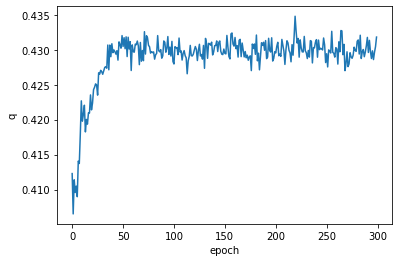

In [11]:
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [12]:
print('Learned parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][5])
print('Interpolation kernel:', mlist[2][5][0])

print()

print('Previous parameters:')
print('Ratio:', mlist[0][:])
print('Restriction kernel:', mlist[1][0][6])
print('Interpolation kernel:', mlist[2][6][0])


Learned parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[ 0.4559, -0.3972,  0.0572],
        [-0.4051, -0.0182,  0.3990],
        [ 0.0558,  0.3971, -0.0686]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2865, 0.5281, 0.2811],
        [0.5280, 0.9729, 0.3286],
        [0.2816, 0.3284, 0.1176]], grad_fn=<SelectBackward0>)

Previous parameters:
Ratio: tensor([4., 1.])
Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)


In [13]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,'model_multigrid_interface_kernel.pth')))

<All keys matched successfully>

In [14]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 0.11738956719636917
1 0.03869187459349632
2 0.014399256557226181
3 0.00552083645015955
4 0.0021587701048702
5 0.0008528736070729792
6 0.00034100544871762395
7 0.0001374189305352047
8 5.6028919061645865e-05
9 2.270502045575995e-05
Solution converges after 10 multi-grid iterations 


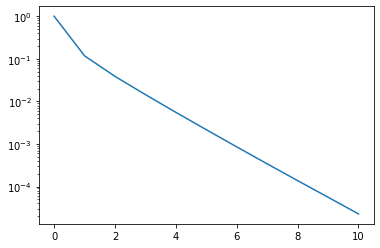

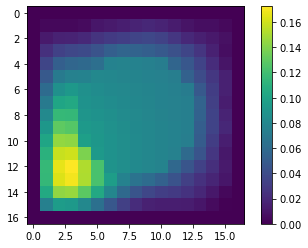

In [15]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [16]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_R, linear_tensor_P, linear_ratio)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w
        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        self.w.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.22294704616069794
0.13798845644916333 0.11125761270523071
0.011720495493664695 0.044469766318798065
0.011036531350644481 0.016820011660456657
0.0068445611936487575 0.006714546121656895
0.002955715704700331 0.002911544404923916
0.0010647564670445131 0.0013408095110207796
0.0003484337295840678 0.0006416418473236263
0.00011566845168025494 0.0003176702302880585
4.590081066982837e-05 0.00016098217747639865
2.2196308095952022e-05 8.261210314230993e-05
1.0392015198761395e-05 4.2568764911266044e-05
Solution converges after 12 V-cycle iterations with relative error of 1.0392015198761395e-05


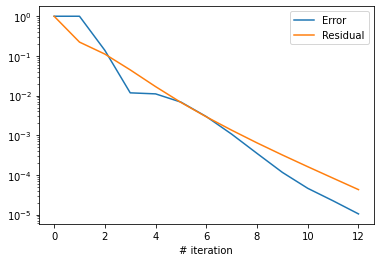

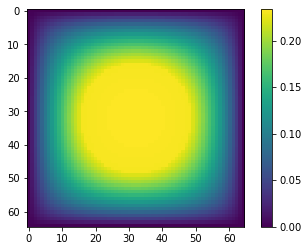

In [17]:
# Multigrid implementation
n = 2**6
prob_mg = mgTest(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [18]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.5747292162190066
